In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
import os.path as osp

classes = ('R', 'G', 'B')
palette = [[0, 0, 255], [0, 255, 0], [255, 0, 0]]

@DATASETS.register_module()
class LineRemoveDataset(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.jpg', 
                     split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# Copyright (c) OpenMMLab. All rights reserved.
import torch.nn as nn
import torch.nn.functional as F

from mmseg.models.builder import LOSSES
from mmseg.models.losses.utils import weighted_loss


@weighted_loss
def mse_loss(pred, target):
    """Warpper of mse loss."""
    return F.mse_loss(pred, target, reduction='none')



@LOSSES.register_module()
class MSELoss(nn.Module):
    """MSELoss.

    Args:
        reduction (str, optional): The method that reduces the loss to a
            scalar. Options are "none", "mean" and "sum".
        loss_weight (float, optional): The weight of the loss. Defaults to 1.0
    """

    def __init__(self, reduction='mean', loss_weight=1.0):
        super().__init__()
        self.reduction = reduction
        self.loss_weight = loss_weight

    def forward(self,
                pred,
                target,
                weight=None,
                avg_factor=None,
                reduction_override=None):
        """Forward function of loss.

        Args:
            pred (torch.Tensor): The prediction.
            target (torch.Tensor): The learning target of the prediction.
            weight (torch.Tensor, optional): Weight of the loss for each
                prediction. Defaults to None.
            avg_factor (int, optional): Average factor that is used to average
                the loss. Defaults to None.
            reduction_override (str, optional): The reduction method used to
                override the original reduction method of the loss.
                Defaults to None.

        Returns:
            torch.Tensor: The calculated loss
        """
        assert reduction_override in (None, 'none', 'mean', 'sum')
        reduction = (
            reduction_override if reduction_override else self.reduction)
        loss = self.loss_weight * mse_loss(
            pred, target, weight, reduction=reduction, avg_factor=avg_factor)
        return loss


In [ ]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device
from mmcv import Config

cfg = Config.fromfile('../configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

data_root = '../data'
img_dir = 'img_dir'
ann_dir = 'ann_dir'
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.auxiliary_head = None
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.pretrained = None
# cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'LineRemoveDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu =2
cfg.data.workers_per_gpu=1

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (768, 768)

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    # dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            # dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/datamy'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

cfg.model.decode_head.loss_decode = dict(loss_weight=1.0, type='MSELoss')

cfg.model.decode_head.num_classes = 3
# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
import mmcv
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.jpg')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

In [36]:
import numpy as np
target = np.load('/spc/home/andy/Downloads/private/mmsegmentation/target.npy')
pred = np.load('/spc/home/andy/Downloads/private/mmsegmentation/pred.npy')
result = np.load('/spc/home/andy/Downloads/private/mmsegmentation/result.npy')
img = np.load('/spc/home/andy/Downloads/private/mmsegmentation/img.npy')

In [9]:
np.sum(np.abs(target) > 0.5)

25662

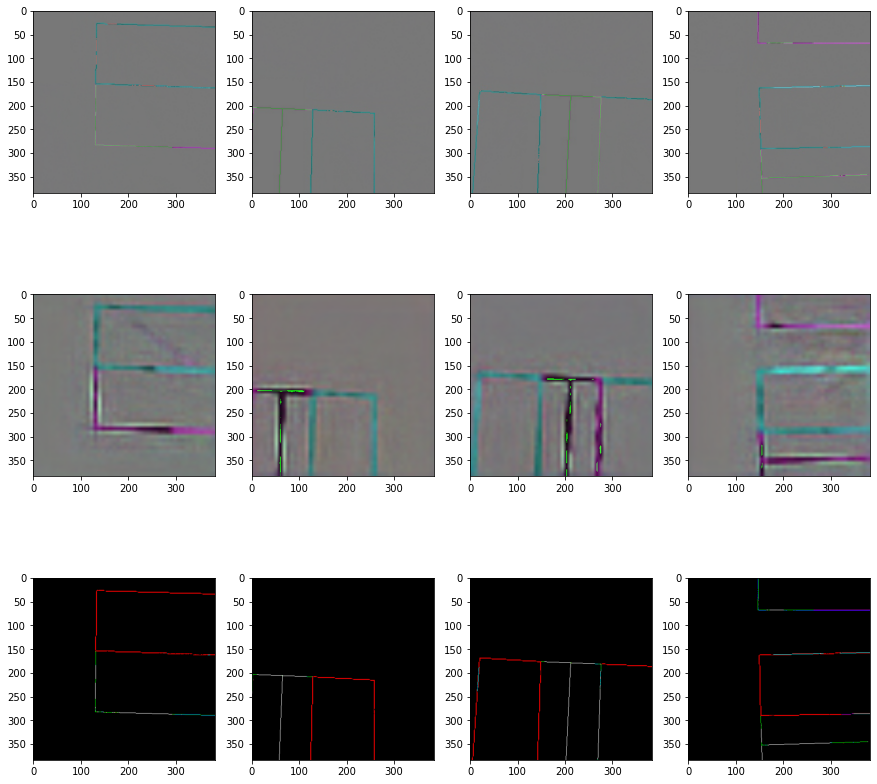

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,20))
LINE_CNT = 4
LINE_MAX = 4
for i in range(LINE_MAX):
    plt.subplot(LINE_CNT,LINE_MAX,i+1)
    plt.imshow((target[i].transpose(1,2,0)*55+120).astype(np.uint8))
    plt.subplot(LINE_CNT,LINE_MAX,i+LINE_MAX+1)
    plt.imshow((pred[i].transpose(1,2,0)*55+120).astype(np.uint8))
    plt.subplot(LINE_CNT,LINE_MAX,i+LINE_MAX*2+1)
    plt.imshow((np.abs(target[i]) > 1).transpose(1,2,0)*250)
    
# plt.subplot(3,3,7)
# plt.imshow(result[0].transpose(1,2,0))
# plt.subplot(3,3,8)
# plt.imshow(img.transpose(1,2,0))
# plt.subplot(3,3,9)
# plt.imshow((img+result[0]).transpose(1,2,0))

In [6]:
for i in range(8):
    print(f'[{i}]={(target[i]-pred[i]).sum()}, pred.sum={pred[i].sum()}, target.sum={target[i].sum()}, target > 1 = {(np.abs(target[i]) >0.5).sum()}')

[0]=-13180.5009765625, pred.sum=14094.21875, target.sum=913.7182006835938, target > 1 = 3599
[1]=-1613.590087890625, pred.sum=2930.93359375, target.sum=1317.3433837890625, target > 1 = 2115
[2]=2837.638671875, pred.sum=-2332.88671875, target.sum=504.7519836425781, target > 1 = 3682
[3]=-7591.94921875, pred.sum=6198.3203125, target.sum=-1393.6282958984375, target > 1 = 4393
[4]=2807.372314453125, pred.sum=-2764.357177734375, target.sum=43.01441955566406, target > 1 = 3572
[5]=2518.04296875, pred.sum=-3056.468994140625, target.sum=-538.42724609375, target > 1 = 2900
[6]=937.7559204101562, pred.sum=-1190.46240234375, target.sum=-252.70620727539062, target > 1 = 3401
[7]=-856.244873046875, pred.sum=2262.6923828125, target.sum=1406.44775390625, target > 1 = 2458


In [ ]:
import torch.nn.functional as F
import torch

loss = F.mse_loss(torch.tensor(pred), torch.tensor(target), reduction='sum')
loss

In [33]:
np.sum(np.abs(pred[0]-target[0]) < 0.1)/(384*384.0*3)

0.7247585720486112

In [ ]:
import math
import numpy as np

v,w = 10, 0.2
R = v / w

L = np.arange(10)
x = R - R * np.cos(w * L / v)
LL = np.multiply(L, L)
x1 = np.divide(w*LL, (v + np.sqrt(v*v-w*w*LL)))

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.plot(L, x)
plt.subplot(1, 3, 2)
plt.plot(L, x1)
plt.subplot(1, 3, 3)
plt.plot(L, x-x1)
